In [1]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')

In [2]:
import os
import gc
import ast
import cv2
import copy
import time
import yaml
import random
import shutil
import warnings
import torchaudio
import subprocess
import numpy as np
import pandas as pd
import IPython.display as ipd
import matplotlib.pyplot as plt
from glob import glob as glob_file
from tqdm import tqdm
from PIL import Image, ImageDraw
from shutil import copyfile
from IPython.core.display import Video, display
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.model_selection import train_test_split, KFold, GroupKFold, StratifiedKFold

import timm
from torch import nn
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn.modules.loss import _WeightedLoss
from torchvision import models, transforms
from fastai.vision.all import *
from huggingface_hub import snapshot_download
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, Wav2Vec2FeatureExtractor

from albumentations.pytorch import ToTensorV2
from albumentations import (
    Compose, OneOf, Normalize, Resize,
    Flip, HorizontalFlip, VerticalFlip, CenterCrop, RandomResizedCrop,
    Rotate, ShiftScaleRotate, RandomRotate90, Transpose,
    RGBShift, ChannelShuffle, HueSaturationValue, RandomBrightnessContrast,
    Blur, MotionBlur, MedianBlur, GaussNoise, Cutout, CoarseDropout
)

warnings.simplefilter('ignore')
pd.set_option("max_columns", 150)
pd.set_option('display.max_rows', 150)

In [3]:
CFG = {
    "save_prev"     : [True, ["*.pth"]],
    "seed"          : 42,
    'device'        : "cuda:0" if torch.cuda.is_available() else "cpu",
    "base_path"     : "../input/birdclef-2022/",
    "img_path"      : "../input/birdclef-spectrograms-all-birds-dataset-224/",
    "output_path"   : './',
    "n_sample_train": 200,
    "n_sample_test" : 80,
    "pretrain"      : None,
    "save_name"     : "birdclef_swin_wav2vec",
    "model"         : "swin_large_patch4_window7_224",
    "size"          : 224,
    "valid_pct"     : 0.3,
    "batch_size"    : 8,
    "epochs"        : 5,
    "n_data"        : None,  # Batch * step
    "lr"            : 1e-4,
    "early_stopping": 3,
    "num_workers"   : 4
}

CFG

{'save_prev': [True, ['*.pth']],
 'seed': 42,
 'device': 'cuda:0',
 'base_path': '../input/birdclef-2022/',
 'img_path': '../input/birdclef-spectrograms-all-birds-dataset-224/',
 'output_path': './',
 'n_sample_train': 200,
 'n_sample_test': 80,
 'pretrain': None,
 'save_name': 'birdclef_swin_wav2vec',
 'model': 'swin_large_patch4_window7_224',
 'size': 224,
 'valid_pct': 0.3,
 'batch_size': 8,
 'epochs': 5,
 'n_data': None,
 'lr': 0.0001,
 'early_stopping': 3,
 'num_workers': 4}

In [4]:
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

def seed_everything(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG["seed"])

In [5]:
if CFG['save_prev'][0]:
    for file_pattern in CFG['save_prev'][1]:
        for f in glob_file(f"../input/.../{file_pattern}"):
            filename = os.path.basename(f)
            print(filename)
            !cp {f} ./{filename}

# Define functions

In [6]:
def get_files(path):
    file_num = []
    for d in os.listdir(path):
        file_num.append([d, len(os.listdir(f"{path}{d}")), f"{path}{d}/"])
    df_file_num = pd.DataFrame(file_num, columns=["bird", "file_num", "path"])
    print("Max,Min:", df_file_num.file_num.max(), df_file_num.file_num.min())
    print("Result shape:", df_file_num.shape)
    return df_file_num

# Load data

In [7]:
# Scored bird names
scored_birds = pd.read_json(f"{CFG['base_path']}scored_birds.json").values.flatten().tolist()
bird2label   = {}
for i, b in enumerate(scored_birds):
    bird2label[b] = i

# No. of files
df_file_num = get_files(CFG["img_path"])

Max,Min: 952 2
Result shape: (152, 3)


,bird,file_num,path
0,bongul,104,../input/birdclef-spectrograms-all-birds-dataset-224/bongul/
1,comgal1,325,../input/birdclef-spectrograms-all-birds-dataset-224/comgal1/


<AxesSubplot:>

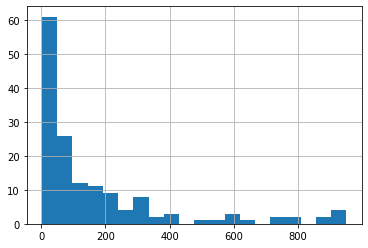

In [8]:
display(df_file_num.head(2))
df_file_num.file_num.hist(bins=20)

(224, 224, 3)


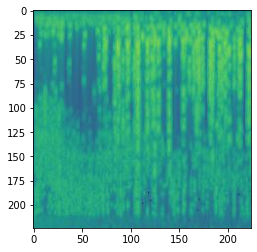

In [9]:
b = 0
n = 0
p = df_file_num.path[b] + os.listdir(df_file_num.path[b])[n]
print(get_img(p).shape)
plt.imshow(get_img(p))

In [10]:
image_paths = []
for label, (b, p) in enumerate(zip(df_file_num.bird, df_file_num.path)):
    train_n = int(len(os.listdir(p))*0.7)
    test_n  = min(len(os.listdir(p)) - train_n, CFG["n_sample_test"])
    #print(df_file_num.bird[label], train_n, test_n)
    all_paths   = os.listdir(p)
    test_paths  = random.sample(all_paths, k=test_n)
    train_paths = [ap for ap in all_paths if ap not in test_paths]
    train_paths = random.choices(train_paths, k=CFG["n_sample_train"])
    
    test_paths  = [[1, pi[:pi.find(".ogg")+4], b, label, p + pi] for pi in test_paths]
    train_paths = [[0, pi[:pi.find(".ogg")+4], b, label, p + pi] for pi in train_paths]
    image_paths += train_paths + test_paths
df_train = pd.DataFrame(image_paths, columns=["is_valid", "filename", "label_name", "label", "img_path"])
df_train["audio_path"] = CFG['base_path'] + "train_audio/" + df_train.label_name + "/" + df_train.filename

print(df_train[df_train.is_valid==0].shape, df_train[df_train.is_valid==1].shape)
df_train.head()

(30400, 6) (5199, 6)


,is_valid,filename,label_name,label,img_path,audio_path
0,0,XC511146.ogg,bongul,0,../input/birdclef-spectrograms-all-birds-dataset-224/bongul/XC511146.ogg.000.jpg,../input/birdclef-2022/train_audio/bongul/XC511146.ogg
1,0,XC163061.ogg,bongul,0,../input/birdclef-spectrograms-all-birds-dataset-224/bongul/XC163061.ogg.000.jpg,../input/birdclef-2022/train_audio/bongul/XC163061.ogg
2,0,XC367429.ogg,bongul,0,../input/birdclef-spectrograms-all-birds-dataset-224/bongul/XC367429.ogg.001.jpg,../input/birdclef-2022/train_audio/bongul/XC367429.ogg
3,0,XC516232.ogg,bongul,0,../input/birdclef-spectrograms-all-birds-dataset-224/bongul/XC516232.ogg.001.jpg,../input/birdclef-2022/train_audio/bongul/XC516232.ogg
4,0,XC163061.ogg,bongul,0,../input/birdclef-spectrograms-all-birds-dataset-224/bongul/XC163061.ogg.000.jpg,../input/birdclef-2022/train_audio/bongul/XC163061.ogg


# Define model

Dataloader

In [11]:
class BirdCLEF_Dataset(Dataset):
    
    def __init__(self, df, transforms=None, output_label=True, is_train=True):
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms   = transforms
        self.output_label = output_label
        self.is_train     = is_train
        self.processor    = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        img_path = self.df.loc[index].img_path
        img_num  = int(img_path[-7:-4])  # Extract XXX from XXX.jpg
        img      = get_img(img_path).copy()
        waveform, sr = torchaudio.load(self.df.loc[index].audio_path)
        waveform = waveform[0]
        if len(waveform) < sr*5:
            rep      = round(float(sr*5) / len(waveform))
            waveform = waveform.repeat(int(rep)+1)
            waveform = waveform[:sr*5]
        else:
            sta = sr*5*img_num
            end = sr*5*(img_num+1)
            if len(waveform[sta:end]) == sr*5:
                waveform = waveform[sta:end]
            else:
                waveform = waveform[-sr*5:]
        waveform = self.processor(waveform, sampling_rate=16000, return_tensors="pt").input_values
        # For cross entropy loss
        y = torch.from_numpy(np.array(self.df.loc[index, "label"]))
        if self.transforms:
            if self.is_train:
                # Horizontal flip
                p = np.random.rand(1)
                if p < 0.5:
                    img      = img[:, ::-1]
                    waveform = waveform.flip(0)
                # Shift to right/left (range is -0.3 ~ 0.3 without 0)
                p = np.random.rand(1)
                if p < 0.5:
                    s = random.sample(list(np.arange(-3,0,0.5))+list(np.arange(0.5,3.1,0.5)), k=1)[0]/10 
                    img      = np.roll(img, int(img.shape[1]*s), axis=1)
                    waveform = torch.from_numpy(np.roll(waveform, int(len(waveform)*s)))
            img = self.transforms(image=img)['image']
        if self.output_label:
            return img, waveform.reshape(-1), y
        return img, waveform.reshape(-1)
    
def get_train_transforms():
    return Compose([
        Resize(CFG['size'], CFG['size'], p=1.0),
        OneOf([
            Cutout(max_h_size=5, max_w_size=16),
            CoarseDropout(max_holes=4),
            ], p=0.5),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)], p=1.0)

def get_valid_transforms():
    return Compose([
        Resize(CFG['size'], CFG['size'], p=1.0),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)], p=1.0)

def prepare_dataloader(df):
    df = df.copy()
    train      = df[df.is_valid==0].reset_index(drop=True).copy()
    valid      = df[df.is_valid==1].reset_index(drop=True).copy()
    train_ds   = BirdCLEF_Dataset(train, transforms=get_train_transforms())
    valid_ds   = BirdCLEF_Dataset(valid, transforms=get_valid_transforms(), is_train=False)
    dataloader = DataLoaders.from_dsets(
        train_ds,
        valid_ds,
        seed=CFG["seed"],
        bs=CFG['batch_size'],
        shuffle=True,
        num_workers=CFG['num_workers']
    )
    if -1 < CFG["device"].find("cuda"):
        dataloader = dataloader.cuda()
    return dataloader

Models

In [12]:
class ImageAndAudioModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.img_model   = timm.create_model(model_name, pretrained=pretrained, num_classes=0, in_chans=3)
        self.audio_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h").to(CFG["device"])
        #self.audio_model = audio_model.wav2vec2.feature_extractor.to("cuda")
        num_features = self.img_model.num_features
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(499*32, 1024)
        self.linear2 = nn.Linear(num_features+1024, df_train.label.max()+1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, w):
        x1 = self.img_model(x)
        x2 = self.audio_model(w).logits
        x2 = self.flatten(x2)
        x2 = self.linear1(x2)
        out = torch.cat((x1, x2), 1)
        out = self.dropout(out)
        out = self.linear2(out)
        return out

def get_learner(df):
    dataloader = prepare_dataloader(df)
    if CFG['pretrain'] is None:
        model = ImageAndAudioModel(CFG["model"], pretrained=True)
    else:
        model = ImageAndAudioModel(CFG["model"], pretrained=False)
        model.load_state_dict(torch.load(CFG['pretrain']))
    learner = Learner(
        dataloader,
        model,
        loss_func=CrossEntropyLossFlat(),
        metrics=[F1Score(average="micro"), Precision(average="micro")]).to_fp16()
    return learner

# Train model

In [13]:
learn = get_learner(df_train)
learn.fit_one_cycle(
    CFG["epochs"],
    CFG["lr"],
    cbs=[SaveModelCallback(every_epoch=True),
         EarlyStoppingCallback(monitor='f1_score',
                               comp=np.greater,
                               patience=CFG['early_stopping'])]
)

Downloading:   0%|          | 0.00/159 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/163 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/291 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_large_patch4_window7_224_22kto1k.pth" to /root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth


Downloading:   0%|          | 0.00/360M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch,train_loss,valid_loss,f1_score,precision_score,time
0,2.214343,2.929590,0.328332,0.328332,1:38:46
1,0.834607,2.163995,0.516638,0.516638,1:38:02
2,0.333908,1.827125,0.617234,0.617234,1:38:23
3,0.084882,1.684953,0.658781,0.658781,1:38:23
4,0.038061,1.638781,0.676861,0.676861,1:38:31


In [14]:
for m in os.listdir("./models"):
    new_filename = m.replace("model_", CFG['save_name']+"_epoch")
    shutil.move(f"./models/{m}", f"{CFG['output_path']}{new_filename}")
!rm -rf ./models

del learn
torch.cuda.empty_cache()
gc.collect()

21